# Assignment-1

In [157]:
#importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# required library for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#keeping a copy of original trainind dataset
data = pd.read_csv("Train.csv")

#reading test dataset
test_data = pd.read_csv("test.csv")

In [3]:
# reading training data
train_data = pd.read_csv("Train.csv")
train_data.head() #printing top 5 rows of training data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#printing shape of the training data
train_data.shape

(8523, 12)

In [5]:
#calculating percentage of null value for each columns
round((train_data.isnull().sum() / len(train_data) * 100 ),2)

Item_Identifier               0.00
Item_Weight                  17.17
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.28
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

* Column "Item_Weight" and "Outlet_Size" has missing value more than 15%
* But we will not go for dropping those two columns because their might be chance that this two columns is dependent on response variable

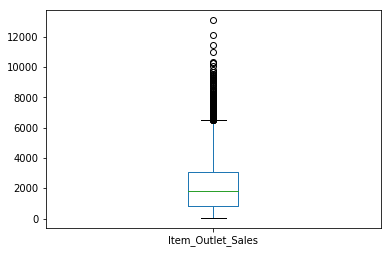

In [155]:
# boxplot for identifying outliers
train_data.Item_Outlet_Sales.plot(kind="box")
plt.show()

* We can clearly observe the outliers
* Maximum values of the response variable sales price lies above 7000 

# NOTE:
   * As the above value is greater than 1, that means data is positively skewed
   * We need to go for the squre root or log transformation
   * But before treating outliers we need to clean the data that means missing value treatment

In [8]:
# we are dropping the column "Item_Identifier" though it will not take any part of predicting sales

train_data.drop("Item_Identifier", axis=1, inplace=True)

In [9]:
# drop column Outlet_Identifier for above reason
train_data.drop("Outlet_Identifier", axis=1, inplace=True)

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Lets impute missing value in column "Item_Weight" by using KNN imputation

from missingpy import KNNImputer
#creating a imputer object
imputer = KNNImputer(missing_values="NaN", n_neighbors=3, metric="masked_euclidean")

# now fit the imputer object to the "Item_Weight" column
train_data["Item_Weight"] = imputer.fit_transform(train_data[["Item_Weight"]])

In [12]:
#lets check wheather "Item_Weight" has missing value or not
train_data.Item_Weight.isnull().sum()

0

In [13]:
# In column "Item_Fat_Content" check frequency of eaach category
train_data.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

* Actually there is 2 category only "low fat" and "regular"
* Replace "Low Fat, low fat" in single LF and "Regular" in reg class

In [14]:
train_data["Item_Fat_Content"] = train_data["Item_Fat_Content"].replace({"Low Fat":"LF","low fat":"LF","Regular":"reg"})
#check again
train_data.Item_Fat_Content.value_counts()

LF     5517
reg    3006
Name: Item_Fat_Content, dtype: int64

In [15]:
#Lets check "Item_Type" column
train_data.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [16]:
#Lets devide Item_Type into some common category
#[Snack Foods,Frozen Foods,Seafood,Starchy Foods,Breads,Meat,Breakfast] = Foods,[Dairy,Soft Drinks,Hard Drinks] = Drinks,
#[Household,Canned,Others,Health and Hygiene,Baking Goods] = Others, [Fruits and Vegetables] = Fruit_Veg

train_data["Item_Type"] = train_data["Item_Type"].replace({"Snack Foods":"Food","Frozen Foods":"Food","Seafood":"Food",
                                                          "Starchy Foods":"Food","Breads":"Food","Meat":"Food",
                                                           "Breakfast":"Food","Dairy":"Drink","Soft Drinks":"Drink",
                                                          "Hard Drinks":"Drink","Household":"Other","Canned":"Other",
                                                          "Others":"Other","Health and Hygiene":"Other",
                                                           "Baking Goods":"Other","Fruits and Vegetables":"Fruit_Veg"})
#Now check wheather it has converted or not
train_data.Item_Type.value_counts()

Food         3054
Other        2896
Drink        1341
Fruit_Veg    1232
Name: Item_Type, dtype: int64

In [17]:
#year is categorical column we can not put directly to the model because it will treat it as a number so that will be prob

#better would be make it numerical by subtracting from current year so that we will get number of year
train_data["Outlet_Establishment_Year"] = 2019 - train_data.Outlet_Establishment_Year
#printing head of year which will now be treates as a number of year
train_data.Outlet_Establishment_Year.head()

0    20
1    10
2    20
3    21
4    32
Name: Outlet_Establishment_Year, dtype: int64

In [18]:
# Lets look into the "Outtlet_Size" column
train_data.Outlet_Size.value_counts(dropna = False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [19]:
#replace "NaN" with "small"
train_data["Outlet_Size"] = train_data["Outlet_Size"].replace({np.nan:"Small"})
# Lets check again "Outtlet_Size" column
train_data.Outlet_Size.isnull().sum()

0

In [20]:
train_data.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [21]:
train_data.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [22]:
final_data = train_data

final_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,LF,0.016047,Drink,249.8092,20,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,reg,0.019278,Drink,48.2692,10,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,LF,0.016760,Food,141.6180,20,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,reg,0.000000,Fruit_Veg,182.0950,21,Small,Tier 3,Grocery Store,732.3800
4,8.93,LF,0.000000,Other,53.8614,32,High,Tier 3,Supermarket Type1,994.7052


In [23]:
# recheck the final data has missing value or not
final_data.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [24]:
#check the shape again
print(final_data.shape)

(8523, 10)


In [25]:
#Lets convert our categorical variable to numerical
final_data.select_dtypes(include="object").columns

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [26]:
final_data["Item_Fat_Content"] = final_data["Item_Fat_Content"].map({"LF":0,"reg":1})

final_data["Item_Type"] = final_data["Item_Type"].map({"Fruit_Veg":0,"Food":1,"Drink":2,"Other":3})

final_data["Outlet_Size"] = final_data["Outlet_Size"].map({"Small":0,"Medium":1,"High":2})

final_data["Outlet_Location_Type"] = final_data["Outlet_Location_Type"].map({"Tier 1":0,"Tier 2":1,"Tier 3":2})

final_data["Outlet_Type"] = final_data["Outlet_Type"].map({"Supermarket Type1":0,"Supermarket Type2":1,
                                                           "Supermarket Type3":2,"Grocery Store":3})

In [27]:
#lets have a final look 
final_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,2,249.8092,20,1,0,0,3735.1380
1,5.92,1,0.019278,2,48.2692,10,1,2,1,443.4228
2,17.50,0,0.016760,1,141.6180,20,1,0,0,2097.2700
3,19.20,1,0.000000,0,182.0950,21,0,2,3,732.3800
4,8.93,0,0.000000,3,53.8614,32,2,2,0,994.7052


##                                         Start Fitting Linear Regression 

# **STEP-1** 

In [50]:
# first take "Item_Visibility" and "Item_MRP" as our predictors

X = final_data[["Item_Visibility","Item_MRP"]]

Y = final_data[["Item_Outlet_Sales"]]

In [51]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6818, 2), (1705, 2), (6818, 1), (1705, 1))

In [52]:
#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [53]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1397.343458144664
R-Squre:  0.33287922721315477


In [65]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(2,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Item_Visibility,-4160.805294
1,Item_MRP,15.537609


### NOTE:
* R-Squre value is 33%, that means 33% varience in Sales is explained by "Item_Visibility" and "Item_MRP"
* If you know these 2 features you can gain 33% info to predict sales accurately
* We can clearly see that "Item MRP" has higher co-efficient than  "Item_Visibility", that means higher MRP will give better sales
    

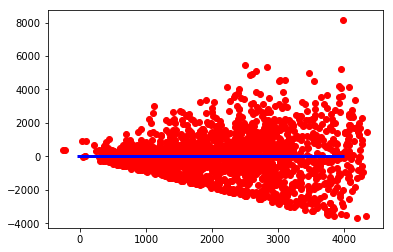

In [74]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=-40, xmax=4000, color="b", linewidth=3)
plt.show()

### NOTE:
* We can clearly observe that errors are not random that means errors are not constant in nature
* plot looks like a funnel shape due to varience of not constant errors
* According to the linear egression assumption we can easily say that heteroskedasticity present in the data
* It happens due to present of outliers in the data

# **STEP-2**

In [75]:
# Add one more columns "Item_Weight" with existing "Item_Visibility" and "Item_MRP" as our predictors

X = final_data[["Item_Weight","Item_Visibility","Item_MRP"]]

Y = final_data[["Item_Outlet_Sales"]]

In [76]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [77]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1397.4584476729813
R-Squre:  0.33276942591997094


In [78]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(3,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Item_Weight,-2.575066
1,Item_Visibility,-4162.856611
2,Item_MRP,15.541931


### NOTE:
* Adding "Item_Weight" column is not improving our R-Squre value at all and CO-Efficient is nearer to Zero
* So we can easily drop this column from our model

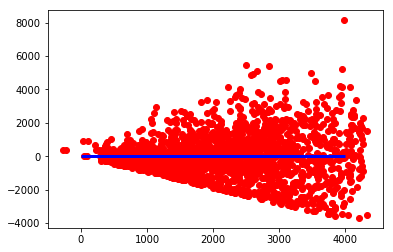

In [80]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=0, xmax=4000, color="b", linewidth=3)
plt.show()

* No improvement in residual plot as there is no changes happened either in RMSE or R-Squre value rather it decrese our R-Squre little

# **STEP-3**

In [81]:
# Add one more columns "Outlet_Establishment_Year" with  "Item_Visibility" and "Item_MRP" as our predictors

X = final_data[["Outlet_Establishment_Year","Item_Visibility","Item_MRP"]]

Y = final_data[["Item_Outlet_Sales"]]

In [82]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [83]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1389.8077466777481
R-Squre:  0.3400552353654429


In [84]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(3,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Outlet_Establishment_Year,10.979581
1,Item_Visibility,-4292.819691
2,Item_MRP,15.542654


### NOTE:
* R-Squre value is increased from 33% to 34% 
* If you know these 3 features you can gain 34% info to predict sales accurately
* "Outlet_Establishment_Year" has good positive co-efficient so we can keep it rather than keeping "Item_visibility"
    

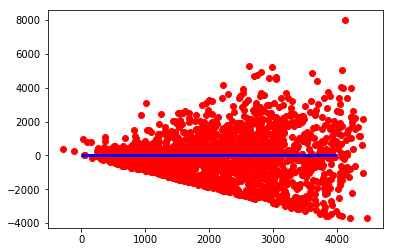

In [86]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=0, xmax=4000, color="b", linewidth=3)
plt.show()

### NOTE:
* Same pattern is being observed in residual plot
* We need to treat the outliers to make our to be distributed randomly

# **STEP-4**

In [87]:
# Add one more columns "Item_Fat_Content","Item_Type" with  existing predictors

X = final_data[["Item_Fat_Content","Item_Type","Outlet_Establishment_Year","Item_Visibility","Item_MRP"]]

Y = final_data[["Item_Outlet_Sales"]]

In [88]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [89]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1388.2326742545874
R-Squre:  0.34155022169052396


In [90]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(5,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Item_Fat_Content,50.769885
1,Item_Type,-5.629756
2,Outlet_Establishment_Year,10.975353
3,Item_Visibility,-4319.785353
4,Item_MRP,15.533119


### NOTE:
* R-Squre value further increase but not that significantly 

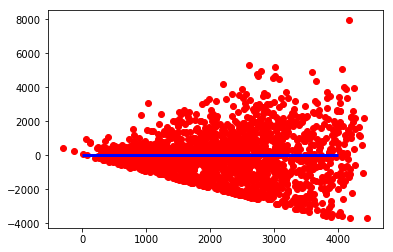

In [92]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=0, xmax=4000, color="b", linewidth=3)
plt.show()

# **STEP-5**

In [93]:
# Add one more columns "Outlet_Size" with  existing predictors

X = final_data[["Item_Fat_Content","Item_Type","Outlet_Establishment_Year","Item_Visibility","Item_MRP","Outlet_Size"]]

Y = final_data[["Item_Outlet_Sales"]]

In [94]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [95]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1365.8737938139418
R-Squre:  0.3625894066027071


### NOTE:
* R-Squre value is 34.155% to 36%
* That means adding "Outlet_Size" we can improve our prediction of sales

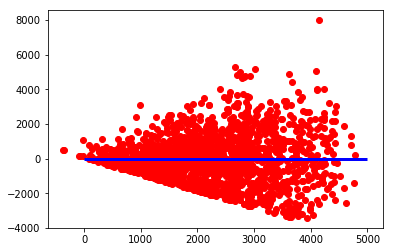

In [98]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=0, xmax=5000, color="b", linewidth=3)
plt.show()

# **STEP-6**

In [99]:
# Add one more columns "Outlet_Location_Type" with  existing predictors

X = final_data[["Item_Fat_Content","Item_Type","Outlet_Establishment_Year","Item_Visibility","Item_MRP","Outlet_Size",
                "Outlet_Location_Type"]]

Y = final_data[["Item_Outlet_Sales"]]

In [100]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [101]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1366.0830477706172
R-Squre:  0.3623940870843705


# Note:
* Error is reducing due to the low bias 
* But model Explained variance not increasing after adding "Outlet_location_Type"

# **STEP-7**

In [102]:
# Add one more columns "Outlet_Size" with  existing predictors

X = final_data[["Item_Fat_Content","Item_Type","Outlet_Establishment_Year","Item_Visibility","Item_MRP",
                "Outlet_Size","Outlet_Type"]]

Y = final_data[["Item_Outlet_Sales"]]

In [103]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [104]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1321.5843299917392
R-Squre:  0.40325623098073604


### NOTE:
* R-Squre value is further increased from 36% to 40%
* That means adding "Outlet_Type" we can improve our prediction of sales better than before

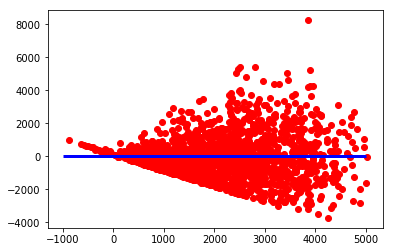

In [107]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=-1000, xmax=5000, color="b", linewidth=3)
plt.show()

# CONCLUSION:
* From the above all the regression model we understand that 
* using "Item_Visibility","Item_MRP","Outlet_Establishment_Year","Outlet_Size","Outlet_Type" these columns we can finally create our final model which will give us maximum result

In [108]:
#Now create our final model using those columns
X = final_data[["Outlet_Establishment_Year","Item_Visibility","Item_MRP","Outlet_Size","Outlet_Type"]]

Y = final_data[["Item_Outlet_Sales"]]

In [109]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [110]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  1322.8896948504687
R-Squre:  0.40207680862805106


# Regularzation Technique

### Ridge Regression

In [126]:
X = final_data.iloc[:,:-1]
Y = final_data.iloc[:,[-1]]

In [127]:
from sklearn.linear_model import Ridge

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
#create a ridge regression object object
alpha_list = [0.01,0.05,0.5,5,10]

for i in alpha_list:
    ridge_reg = Ridge(alpha = i, normalize=True)
    ridge_reg.fit(X_train, Y_train)
    y_pred1 = ridge_reg.predict(X_test)
    print("R-Squre {} for alpha={}" .format(r2_score(Y_test, y_pred1), i))

R-Squre 0.42044481074266316 for alpha=0.01
R-Squre 0.41849322132169187 for alpha=0.05
R-Squre 0.36461883560214925 for alpha=0.5
R-Squre 0.12656875432414172 for alpha=5
R-Squre 0.07225312920132754 for alpha=10


## Note:
* for alpha 0.01 above model is giving more R-Squre nearly 42%
* for rest of the alpha value R-Squre value is decreasing

In [133]:
# Fit the model using alpha 0.01

ridge_reg = Ridge(alpha = 0.01, normalize=True)
ridge_reg.fit(X_train, Y_train)
y_pred1 = ridge_reg.predict(X_test)
print("R-Squre: ",r2_score(Y_test, y_pred1))

R-Squre:  0.42044481074266316


In [140]:
ridge_reg.coef_

array([[   -2.97307096,    45.694154  , -2173.53630179,    -7.5346968 ,
           15.37124041,    40.00095211,  -113.51191285,   394.39684713,
         -520.3265853 ]])

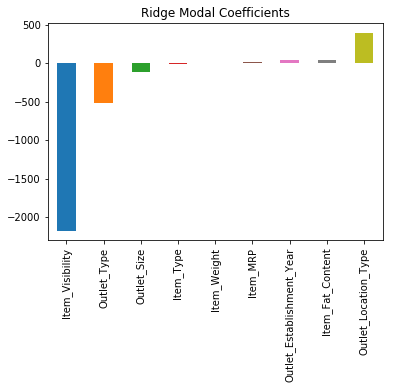

In [142]:
#checking the magnitude of coefficients

predictors = X_train.columns

coef = pd.Series([-2.97307096,45.694154,-2173.53630179,-7.5346968 ,15.37124041,40.00095211,-113.51191285, 394.39684713,-520.3265853 ],
              predictors).sort_values()

coef.plot(kind='bar', title='Ridge Modal Coefficients')
plt.show()

## NOTE:
* clearly observe above that when alpha 0.01 the R-Squre value is maximum
* In lasso if we increase the alpha co-efficient will reach to zero but not absolute zero
* It will not drop the column but will put lesser weightage to the co-efficient which variable is not giving that much info about the independancy variable,it will select the column according to its dependancy on sales

# Lasso Regression

In [143]:
from sklearn.linear_model import Lasso

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
#create a ridge regression object object
alpha_list = [0.001,0.01,0.05,0.5,5,10]

for i in alpha_list:
    lasso_reg = Lasso(alpha = i, normalize=True)
    lasso_reg.fit(X_train, Y_train)
    y_pred2 = lasso_reg.predict(X_test)
    print("R-Squre {} for alpha={}" .format(r2_score(Y_test, y_pred2), i))

R-Squre 0.42054055705240045 for alpha=0.001
R-Squre 0.420507374964624 for alpha=0.01
R-Squre 0.42024006051684104 for alpha=0.05
R-Squre 0.4131054755119197 for alpha=0.5
R-Squre 0.25702911787745186 for alpha=5
R-Squre 0.08675970968730762 for alpha=10


## NOTE:
* clearly observe that when alpha 0.001 the R-Squre value is maximum
* In lasso if we increase the alpha co-efficient will reach to absolute zero
* It is a kind of features extraction, it will select the column according to its dependancy on sales

In [175]:
# Fit the model using alpha 0.001

lasso_reg = Lasso(alpha = 0.001, normalize=True)
lasso_reg.fit(X_train, Y_train)
y_pred2 = lasso_reg.predict(X_test)
print("R-Squre: ",r2_score(Y_test, y_pred2))

R-Squre:  0.42054055705240045


In [176]:
lasso_reg.coef_

array([   -3.00885734,    46.16761036, -2158.69574799,    -7.27683091,
          15.52318616,    42.04885446,  -137.70897948,   413.00388149,
        -537.5926836 ])

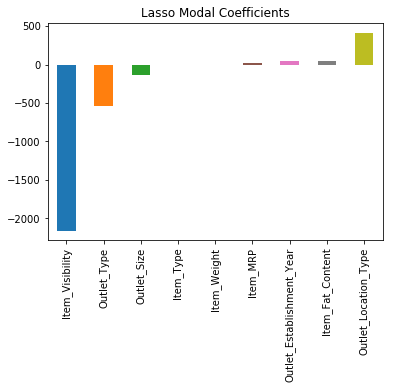

In [153]:
#checking the magnitude of coefficients

predictors = X_train.columns

coef = pd.Series([-3.00885734, 46.16761036, -2158.69574799, -7.27683091,15.52318616,42.04885446,-137.70897948,413.00388149,-537.5926836],
              predictors).sort_values()

coef.plot(kind='bar', title='Lasso Modal Coefficients')
plt.show()

### NOW WE WILL PREDICT SALES USING THE TEST DATA SET

In [154]:
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [166]:
test_data.drop(["Item_Identifier","Outlet_Identifier"], axis=1, inplace=True)

In [167]:
test_data.shape

(5681, 9)

In [168]:
test_data.isnull().sum()/len(test_data)

Item_Weight                  0.171801
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282697
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
dtype: float64

In [171]:
test_data["Item_Weight"] = imputer.fit_transform(test_data[["Item_Weight"]])
test_data["Item_Fat_Content"] = test_data["Item_Fat_Content"].replace({"Low Fat":"LF","low fat":"LF","Regular":"reg"})
test_data["Outlet_Establishment_Year"] = 2019 - test_data.Outlet_Establishment_Year
test_data["Item_Type"] = test_data["Item_Type"].replace({"Snack Foods":"Food","Frozen Foods":"Food","Seafood":"Food",
                                                          "Starchy Foods":"Food","Breads":"Food","Meat":"Food",
                                                           "Breakfast":"Food","Dairy":"Drink","Soft Drinks":"Drink",
                                                          "Hard Drinks":"Drink","Household":"Other","Canned":"Other",
                                                          "Others":"Other","Health and Hygiene":"Other",
                                                           "Baking Goods":"Other","Fruits and Vegetables":"Fruit_Veg"})

test_data["Outlet_Size"] = test_data["Outlet_Size"].replace({np.nan:"Small"})

test_data["Item_Fat_Content"] = test_data["Item_Fat_Content"].map({"LF":0,"reg":1})

test_data["Item_Type"] = test_data["Item_Type"].map({"Fruit_Veg":0,"Food":1,"Drink":2,"Other":3})

test_data["Outlet_Size"] = test_data["Outlet_Size"].map({"Small":0,"Medium":1,"High":2})

test_data["Outlet_Location_Type"] = test_data["Outlet_Location_Type"].map({"Tier 1":0,"Tier 2":1,"Tier 3":2})

test_data["Outlet_Type"] = test_data["Outlet_Type"].map({"Supermarket Type1":0,"Supermarket Type2":1,
                                                           "Supermarket Type3":2,"Grocery Store":3})

In [172]:
test_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,20.750000,0,0.007565,1,107.8622,20,1,0,0
1,8.300000,1,0.038428,2,87.3198,12,0,1,0
2,14.600000,0,0.099575,3,241.7538,21,0,2,3
3,7.315000,0,0.015388,1,155.0340,12,0,1,0
4,12.695633,1,0.118599,2,234.2300,34,1,2,2


In [178]:
x_test = test_data.iloc[:,:]

In [179]:
test_data["Item_Outlet_Sales"] = lasso_reg.predict(x_test)

In [180]:
test_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,20.750000,0,0.007565,1,107.8622,20,1,0,0,1575.868294
1,8.300000,1,0.038428,2,87.3198,12,0,1,0,1481.034390
2,14.600000,0,0.099575,3,241.7538,21,0,2,3,2852.609132
3,7.315000,0,0.015388,1,155.0340,12,0,1,0,2545.982272
4,12.695633,1,0.118599,2,234.2300,34,1,2,2,3700.441101
